## Project - 7. Classification of images.
### #1 We will use Xception network which pre-trained on ImageNet and retrain if for our task. So, result - Baseline
### #2 We will use EfficientNetB6 network pre-trained on ImageNet and retrain if for our task. So, result - new Baseline
### #3 We will use finetuning base on #2 model
### #4 We will try to use TTA on #3 model and compare scores before and after. 

In [1]:
!nvidia-smi

Tue Jun 22 08:43:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.applications import Xception, EfficientNetB6
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#Lets increase the default size of the charts
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#The graths in 'svg' look more clearer
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sf-dl-car-classification']
Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [3]:
# We take out the main settings in setup: this way 
# is more convenient to sort them out in the future

EPOCHS               = 25  # epochs for training
BATCH_SIZE           = 32 # reduce the batch if the network is large, otherwise it will not fit in the memory on the GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # percent allocate data for test = 15%

RANDOM_SEED          = 42
CLASS_NUM            = 10  # the number of classes in our task
IMG_SIZE             = 224 # images size which we send to network
IMG_CHANNELS         = 3   # RGB gas 3 channels
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "../working/car/" # workdir

### EDA

In [4]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [6]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

We have fairly uniform distribution

Lets look on images:

In [7]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/sf-dl-car-classification/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


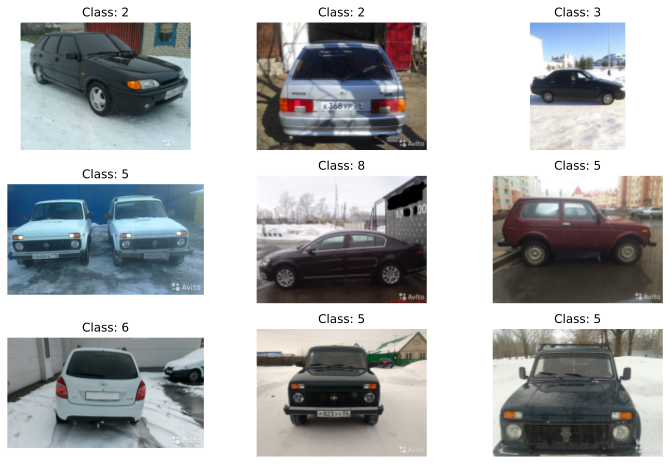

In [8]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Let's look at the sample images and their sizes to understand how better to process and compress them.

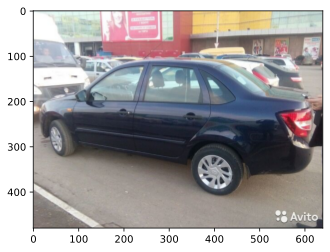

(640, 480)

In [9]:
image = PIL.Image.open(PATH+'/train/0/100306.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

## Data Augmentation

We work with a small dataset, so augmentation is important for us.

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=50,
    shear_range=0.2,
    zoom_range=[0.75, 1.25],
    brightness_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

tta_datagen = ImageDataGenerator(rescale=1. / 255,
                                     rotation_range=90,
                                     shear_range=0.2,
                                     zoom_range=[0.75, 1.25],
                                     brightness_range=[0.5, 1.5],
                                     width_shift_range=0.1,
                                     height_shift_range=0.1)

## Data Generation
Let's wrap our data in a generator

In [11]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # the directory where the folders with pictures are located
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

tta_generator = tta_datagen.flow_from_dataframe(
        dataframe=sample_submission,
        directory=PATH+'test_upload/',
        x_col="Id",
        y_col=None,
        shuffle=False,
        class_mode=None,
        seed=RANDOM_SEED,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.
Found 6675 validated image filenames.


## Models, which we will use

### Base model#1 Xception
with change "head"

In [12]:
def base_model_Xception(input_shape, lr = 1e-4):
    '''
    Xception + new head with batchnorm
    '''
    base_model = Xception(weights='imagenet',
                                include_top=False,
                                input_shape=input_shape)

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    # let's add a fully-connected layer
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu', 
                      bias_regularizer=l2(1e-4),
                      activity_regularizer=l2(1e-5)))
    model.add(Dropout(0.25))
    # and a logistic layer -- let's say we have 10 classes
    model.add(Dense(CLASS_NUM, activation='softmax'))
    model.compile(loss="categorical_crossentropy", 
                  optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])
    return model, base_model

### Base model EfficientNetB6
Change "head"

##### In previous versions of the code, this model gave poor results, which is why it was removed.

In [13]:
'''
def base_model_EfficientNetB6(input_shape, lr = 1e-4):
    
    #EfficientNetB6 + new head with batchnorm
    
    base_model = EfficientNetB6(weights='imagenet',
                                include_top=False,
                                input_shape=input_shape)

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    # let's add a fully-connected layer
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    # and a logistic layer -- let's say we have 10 classes
    model.add(Dense(CLASS_NUM, activation='softmax'))
    model.compile(loss="categorical_crossentropy", 
                  optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])
    return model, base_model
    
    '''


'\ndef base_model_EfficientNetB6(input_shape, lr = 1e-4):\n    \n    #EfficientNetB6 + new head with batchnorm\n    \n    base_model = EfficientNetB6(weights=\'imagenet\',\n                                include_top=False,\n                                input_shape=input_shape)\n\n    model = Sequential()\n    model.add(base_model)\n    model.add(GlobalAveragePooling2D())\n    # let\'s add a fully-connected layer\n    model.add(Dense(256, activation=\'relu\'))\n    model.add(BatchNormalization())\n    model.add(Dropout(0.25))\n    # and a logistic layer -- let\'s say we have 10 classes\n    model.add(Dense(CLASS_NUM, activation=\'softmax\'))\n    model.compile(loss="categorical_crossentropy", \n                  optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])\n    return model, base_model\n    \n    '

## Models training
### Let's adding  ModelCheckpoint

In [14]:
checkpoint = ModelCheckpoint('best_model.hdf5' , 
                             monitor = ['val_accuracy'] , 
                             verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy',
                              patience=5,
                              restore_best_weights=True)
callbacks_list =[earlystop, checkpoint]

### Fit, predict and submit functions

In [15]:
def plot_history_new(history, model_name='model', score=''):
    plt.figure(figsize = (10,5))
    plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.plot(epochs,acc,'b',label = 'Training acc')
    plt.plot(epochs, val_acc, 'g', label = 'Validation acc')
    plt.title('Training and validation ' + f'accuracy {model_name}. {score}')
    plt.legend()
    
    plt.figure(figsize = (10,5))
    plt.style.use('dark_background')
    plt.plot(epochs,loss,'b',label = 'Training loss')
    plt.plot(epochs, val_loss, 'g', label = 'Validation loss')
    plt.title('Training and validation '+ f'loss {model_name}')
    plt.legend()
    
    plt.show()
    
def plot_history_old(history):
    plt.figure(figsize = (10,5))
    plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.plot(epochs,acc,'b',label = 'Training acc')
    plt.plot(epochs, val_acc, 'g', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure(figsize = (10,5))
    plt.style.use('dark_background')
    plt.plot(epochs,loss,'b',label = 'Training loss')
    plt.plot(epochs, val_loss, 'g', label = 'Validation loss')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.show()

def unfreeze_model(model, ratio=0):
    '''
    Unfreeze model layers.
    ratio - [0,1], 1 - all layers trainable.
    '''
    if 0 < ratio <= 1:
        model.trainable = True
        fine_tune_at = round(len(model.layers) * ratio)
        for layer in model.layers[:-fine_tune_at]:
            layer.trainable = False
    else:
        model.trainable = False


def compile_model(model, lr=1e-3):
    '''
    Compile model
    '''
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.Adam(lr),
                  metrics=["accuracy"])
    
    
def fine_tune_fit(model_input, input_shape, steps=[],
                  weights=None, unfreeze_ratio=0):
    """
    Build and fine-tune model over list of steps.
    Each step - (lr, unfreeze_ratio, epochs)
    """

    model, base_model = model_input(input_shape)
    if weights:
        # load weights from 'best_model.hdf5'
        # (_, ratio, _) = steps[0]
        unfreeze_model(base_model, ratio=unfreeze_ratio)
        model.load_weights(weights)

    for step, (lr, ratio, epochs) in enumerate(steps):

        step += 1  # for printing [1..N]
        unfreeze_model(base_model, ratio)
        compile_model(model, lr)
        model_name = model.name + \
            '_e' + str(epochs) + \
            '_lr_'+str(lr) + \
            '_ufratio_'+str(ratio) + \
            '_i'+str(IMG_SIZE)

        # scores = model.evaluate(val_generator, verbose=1)
        print(f"{'-'*40}\n" +
              f"{step}/{len(steps)} step training\n" +
              #   f"before {step} training\n" +
              #   f"Accuracy: {scores[1]*100:.2f}\n" +
              #   f"{'-'*40}\n" +
              f"Start training. Unfreeze: {ratio}, LR: {lr}\n" +
              f"{'-'*40}")

        history = model.fit(
            train_generator,
            steps_per_epoch = len(train_generator),
            validation_data = test_generator, 
            validation_steps = len(test_generator),
            epochs=epochs,
            callbacks=callbacks_list
        )

        model.save(f'{model_name}_step{step}.hdf5')
        model.load_weights('best_model.hdf5')
       
        scores = model.evaluate(test_generator, verbose=1)
        print(f"{'-'*21}\n" +
              f"Accuracy step {step}: {scores[1]*100:.2f}\n" +
              f"{'-'*21}")
        plot_history_new(history,
                     model_name,
                     f'Accuracy step {step}: {scores[1]*100:.2f}')
        # print(f'Running time: {datetime.now() - start_time}')

    return model


def create_submission(predictions, name=''):
    """
    Create submission file from prediction
    """
    
    predictions = np.argmax(predictions, axis=-1)  # multiple categories
    label_map = (train_generator.class_indices)
    label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
    predictions = [label_map[k] for k in predictions]
    
    #tta_pred = predict_tta(model)

    !rm -rf /kaggle/working/car/train
    !rm -rf /kaggle/working/car/test_upload
    
    filenames_with_dir = test_sub_generator.filenames
    #let's save xception
    submission = pd.DataFrame(
        {'Id': filenames_with_dir,
         'Category': predictions},
        columns=['Id', 'Category'])
    submission['Id'] = submission['Id'].replace('test_upload/', '')
    submission.to_csv(f'{name}_submission.csv', index=False)
    #let's save tta_xception
    #submission_2 = pd.DataFrame(
    #    {'Id': filenames_with_dir,
    #     'Category': tta_pred},
    #     columns=['Id', 'Category'])
    # submission_2['Id'] = submission_2['Id'].replace('test_upload/', '')
    #submission_2.to_csv('tta_xcept_submission.csv', index=False)


def predict_submit(model, name=''):
    """
    Create submission file from prediction,
    return predictions
    """
    predictions = model.predict(test_sub_generator, verbose=1)
    create_submission(predictions, name=name)
    return predictions


def predict_tta(model, tta_steps=10):
    """
    Prediction with TTA
    """
    predictions = []

    for i in range(tta_steps):
        preds = model.predict(test_sub_generator, verbose=1)
        predictions.append(preds)

    pred = np.mean(predictions, axis=0)
    return pred

Let's look on score before trainig our model.

### Model #1 (Xception)

In [16]:
work_model = base_model_Xception
xception_model,xception_base = base_model_Xception(input_shape)

83689472/83683744 [==============================] - 1s 0us/step


In [17]:
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# Steps - list of steps (learning rate, unfreeze_ratio, epochs)
#  unfreeze_ratio: 0.0 - freeze, 1.0 - unfreeze base model
steps = [(1e-4, 0, 12), #было 5
         (1e-4, 0.5, 12),
         (1e-5, 1, 12)
        ]

Let's see on scores before training our model, so we have about 5-10% accuracy.

In [18]:
scores = xception_model.evaluate_generator(test_generator, steps = 1, verbose = 1)
print('Accuracy: %.2f%%' % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1/1 [==============================] - 6s 6s/step - loss: 2.3456 - accuracy: 0.1875
Accuracy: 18.75%


----------------------------------------
1/3 step training
Start training. Unfreeze: 0, LR: 0.0001
----------------------------------------
Epoch 1/12
414/414 [==============================] - 238s 569ms/step - loss: 2.3395 - accuracy: 0.1715 - val_loss: 1.8565 - val_accuracy: 0.3469

Epoch 00001: saving model to best_model.hdf5
Epoch 2/12
414/414 [==============================] - 234s 566ms/step - loss: 1.9333 - accuracy: 0.2889 - val_loss: 1.6642 - val_accuracy: 0.4152

Epoch 00002: saving model to best_model.hdf5
Epoch 3/12
414/414 [==============================] - 235s 567ms/step - loss: 1.7643 - accuracy: 0.3575 - val_loss: 1.5358 - val_accuracy: 0.4414

Epoch 00003: saving model to best_model.hdf5
Epoch 4/12
414/414 [==============================] - 235s 569ms/step - loss: 1.6769 - accuracy: 0.3938 - val_loss: 1.4572 - val_accuracy: 0.4865

Epoch 00004: saving model to best_model.hdf5
Epoch 5/12
414/414 [==============================] - 236s 571ms/step - loss: 1.5954 - accur

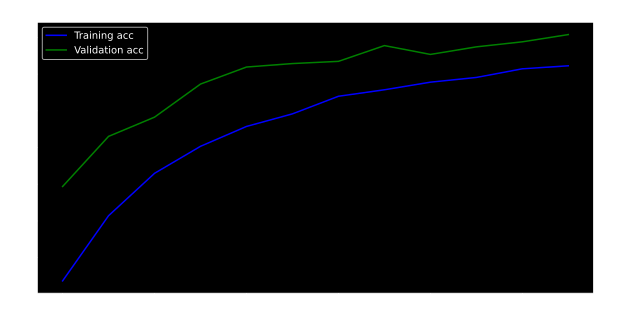

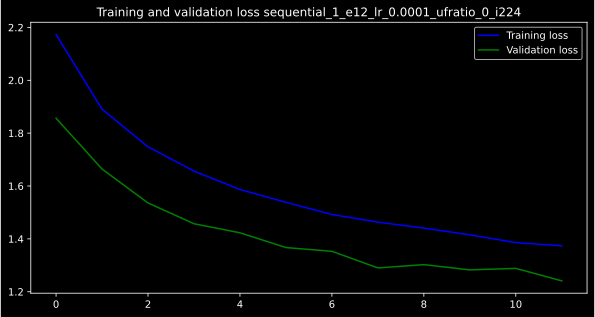

----------------------------------------
2/3 step training
Start training. Unfreeze: 0.5, LR: 0.0001
----------------------------------------
Epoch 1/12
414/414 [==============================] - 252s 599ms/step - loss: 1.3865 - accuracy: 0.5122 - val_loss: 0.8046 - val_accuracy: 0.7055

Epoch 00001: saving model to best_model.hdf5
Epoch 2/12
414/414 [==============================] - 248s 598ms/step - loss: 0.7641 - accuracy: 0.7321 - val_loss: 0.5868 - val_accuracy: 0.7935

Epoch 00002: saving model to best_model.hdf5
Epoch 3/12
414/414 [==============================] - 253s 611ms/step - loss: 0.5724 - accuracy: 0.7916 - val_loss: 0.4605 - val_accuracy: 0.8347

Epoch 00003: saving model to best_model.hdf5
Epoch 4/12
414/414 [==============================] - 252s 607ms/step - loss: 0.4659 - accuracy: 0.8407 - val_loss: 0.4401 - val_accuracy: 0.8424

Epoch 00004: saving model to best_model.hdf5
Epoch 5/12
414/414 [==============================] - 258s 621ms/step - loss: 0.3745 - acc

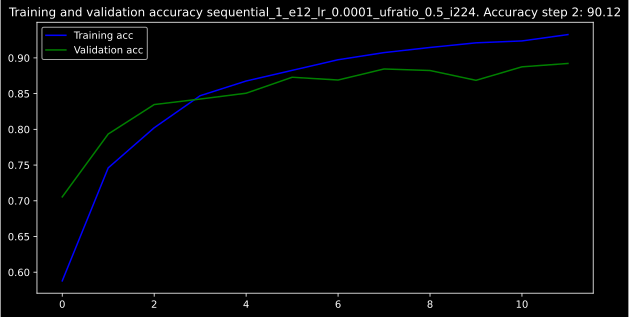

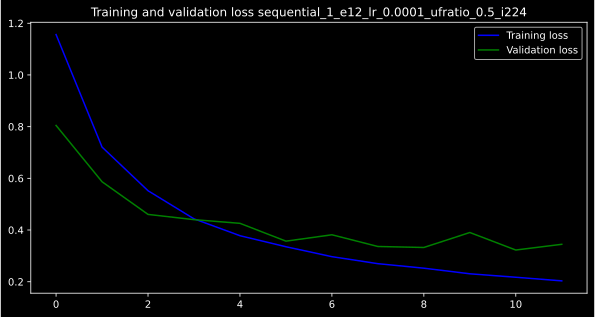

----------------------------------------
3/3 step training
Start training. Unfreeze: 1, LR: 1e-05
----------------------------------------
Epoch 1/12
414/414 [==============================] - 298s 707ms/step - loss: 0.2466 - accuracy: 0.9142 - val_loss: 0.2828 - val_accuracy: 0.9017

Epoch 00001: saving model to best_model.hdf5
Epoch 2/12
414/414 [==============================] - 294s 710ms/step - loss: 0.1961 - accuracy: 0.9301 - val_loss: 0.2893 - val_accuracy: 0.9073

Epoch 00002: saving model to best_model.hdf5
Epoch 3/12
414/414 [==============================] - 294s 710ms/step - loss: 0.1635 - accuracy: 0.9402 - val_loss: 0.2773 - val_accuracy: 0.9081

Epoch 00003: saving model to best_model.hdf5
Epoch 4/12
414/414 [==============================] - 296s 714ms/step - loss: 0.1495 - accuracy: 0.9474 - val_loss: 0.2800 - val_accuracy: 0.9090

Epoch 00004: saving model to best_model.hdf5
Epoch 5/12
414/414 [==============================] - 296s 715ms/step - loss: 0.1490 - accura

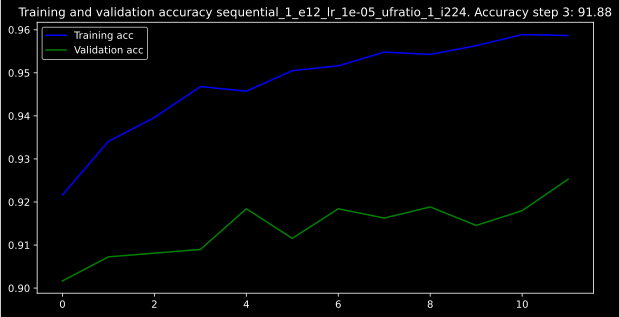

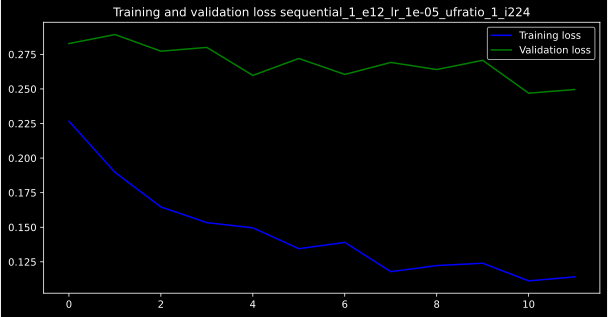

In [19]:
model = fine_tune_fit(work_model, input_shape, steps)

So, we have about 50 - 55% accuracy with our 10-classes model without fine-tuning,
about 89.5% with 50% fine-tuning and maximum 90.5% after training 100% base_model#1 (Xception) layers. As we can see, it is small differrence between 50% and 100% layers training. But it spends 16% more time than 50% layers trainig, compared with 6.25% spent time between 0% and 50% training base_model's layers.


Let's save last model 

In [20]:
model.save('xception_size_224.hdf5')

In [21]:
(_, last_unfreeze_ratio, _) = steps[-1]


Let's increase images

In [22]:
BATCH_SIZE = 16
IMG_SIZE = 448  
input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)


steps = [(1e-5, 0.5, 12),
         (1e-5, 1, 12)]


Let's load previos weights

----------------------------------------
1/2 step training
Start training. Unfreeze: 0.5, LR: 1e-05
----------------------------------------
Epoch 1/12
414/414 [==============================] - 253s 602ms/step - loss: 0.0978 - accuracy: 0.9635 - val_loss: 0.2594 - val_accuracy: 0.9257

Epoch 00001: saving model to best_model.hdf5
Epoch 2/12
414/414 [==============================] - 253s 611ms/step - loss: 0.1012 - accuracy: 0.9621 - val_loss: 0.2630 - val_accuracy: 0.9223

Epoch 00002: saving model to best_model.hdf5
Epoch 3/12
414/414 [==============================] - 249s 602ms/step - loss: 0.0999 - accuracy: 0.9643 - val_loss: 0.2749 - val_accuracy: 0.9141

Epoch 00003: saving model to best_model.hdf5
Epoch 4/12
414/414 [==============================] - 253s 610ms/step - loss: 0.0870 - accuracy: 0.9678 - val_loss: 0.2516 - val_accuracy: 0.9253

Epoch 00004: saving model to best_model.hdf5
Epoch 5/12
414/414 [==============================] - 250s 603ms/step - loss: 0.0920 - accu

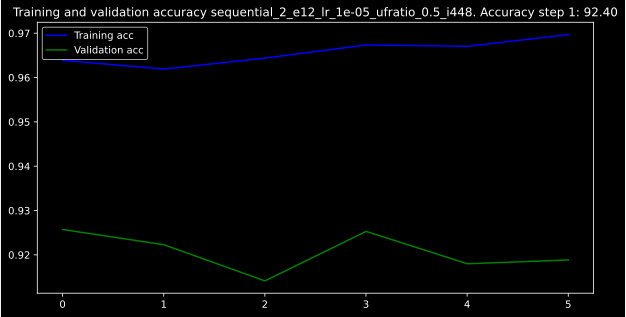

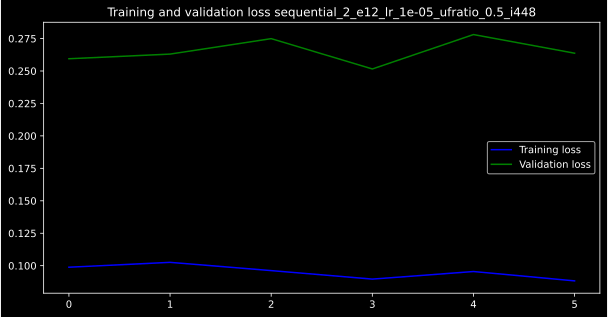

----------------------------------------
2/2 step training
Start training. Unfreeze: 1, LR: 1e-05
----------------------------------------
Epoch 1/12
414/414 [==============================] - 298s 709ms/step - loss: 0.0951 - accuracy: 0.9668 - val_loss: 0.2561 - val_accuracy: 0.9317

Epoch 00001: saving model to best_model.hdf5
Epoch 2/12
414/414 [==============================] - 293s 708ms/step - loss: 0.0962 - accuracy: 0.9645 - val_loss: 0.2660 - val_accuracy: 0.9214

Epoch 00002: saving model to best_model.hdf5
Epoch 3/12
414/414 [==============================] - 292s 705ms/step - loss: 0.0926 - accuracy: 0.9677 - val_loss: 0.2966 - val_accuracy: 0.9188

Epoch 00003: saving model to best_model.hdf5
Epoch 4/12
414/414 [==============================] - 292s 705ms/step - loss: 0.0970 - accuracy: 0.9637 - val_loss: 0.2563 - val_accuracy: 0.9227

Epoch 00004: saving model to best_model.hdf5
Epoch 5/12
414/414 [==============================] - 293s 706ms/step - loss: 0.0930 - accura

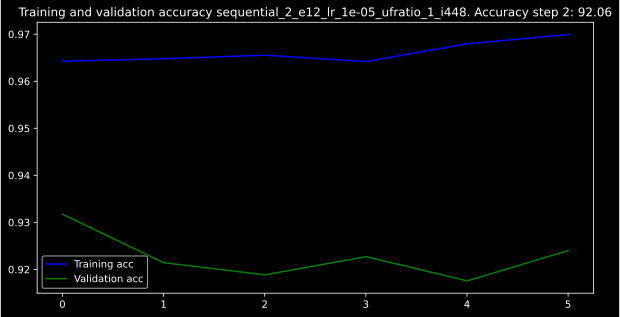

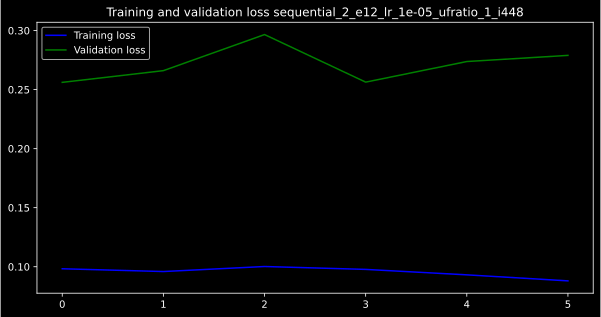

In [23]:
model = fine_tune_fit(work_model, input_shape, steps,
                      weights='best_model.hdf5',
                      unfreeze_ratio=last_unfreeze_ratio)
(_, last_unfreeze_ratio, _) = steps[-1]

Let's save last model

In [24]:
model.save('xception_size_448.hdf5')

### Prediction and Submission

In [25]:
test_sub_generator.samples

6675

In [26]:
#predict_xcept = predict_submit(model, name=model.name)

With using Test Time Augmentation

In [27]:
predict_xcept_tta = predict_tta(model, tta_steps=10)
create_submission(predict_xcept_tta, name='xcept_tta')

209/209 [==============================] - 38s 182ms/step
